Reference: https://www.geeksforgeeks.org/deep-learning/emotion-detection-using-convolutional-neural-networks-cnns/

In [7]:
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# MODEL

## Define MobileNetV2-based emotion model

In [81]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from pathlib import Path

IMG_SIZE = 96
N_CLASSES = 7
BATCH_SIZE = 64


def build_emotion_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")

    # Simple rescaling (you can fancy this up if you like)
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1.0, name="rescale")(inputs)

    # Backbone
    base = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    base.trainable = False  # fine-tune later if needed

    x = base(x)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(0.3, name="dropout")(x)
    outputs = layers.Dense(N_CLASSES, activation="softmax", name="classifier")(x)

    model = models.Model(inputs, outputs, name="emotion_mobilenetv2")

    # Create a helper model that outputs conv features for Grad-CAM
    model.grad_cam_model = tf.keras.Model(
        inputs=model.input,
        outputs=[base.output, model.output],  # Conv features + predictions
    )

    return model

In [82]:
DATA_ROOT = Path("data/RAF-DB/DATASET")
train_dir = DATA_ROOT / "train"
test_dir = DATA_ROOT / "test"

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",  # use folder names 1..7
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("Class names:", train_ds.class_names)

# Prefetch for speed
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 12271 files belonging to 7 classes.
Found 3068 files belonging to 7 classes.
Class names: ['1', '2', '3', '4', '5', '6', '7']


In [84]:
# build and train model
emotion_model = build_emotion_model()
emotion_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = emotion_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.2996 - loss: 2.0817 - val_accuracy: 0.3892 - val_loss: 1.6420
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.3582 - loss: 1.8278 - val_accuracy: 0.4205 - val_loss: 1.5201
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3893 - loss: 1.6996 - val_accuracy: 0.4508 - val_loss: 1.4379
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4119 - loss: 1.6218 - val_accuracy: 0.4723 - val_loss: 1.3830
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.4395 - loss: 1.5434 - val_accuracy: 0.4892 - val_loss: 1.3448
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4521 - loss: 1.4909 - val_accuracy: 0.5046 - val_loss: 1.3143
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4607 - loss: 1.4558 - val_accuracy: 0.5153 - val_loss: 1.2899
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4762 - loss: 1.4295 - val_acc

In [42]:
emotion_model.save("emotion_mobilenet_rafdb.keras")

In [91]:
def grad_cam_visualization(model, img_path, target_class=None):
    """
    Grad-CAM using the mid-level layer block_6_expand.
    """

    # ---- Preprocess ----
    input_tensor, rgb_img = preprocess_image_for_emotion(img_path)
    input_tensor = tf.cast(input_tensor, tf.float32)

    # ---- Backbone + layer ----
    backbone = model.get_layer("mobilenetv2_1.00_96")
    target_layer_name = "block_6_expand"  # <<<<< mid-level layer
    target_layer = backbone.get_layer(target_layer_name)

    # ---- Build a sub-model that outputs:
    #      (1) features from block_6_expand
    #      (2) final predictions
    sub_model = tf.keras.Model(
        inputs=model.input,
        outputs=[target_layer.output, model.output],
        name="grad_cam_model",
    )

    # ---- Forward pass ----
    with tf.GradientTape() as tape:
        feature_maps, preds = sub_model(input_tensor, training=False)
        pred_id = tf.argmax(preds[0]).numpy()

        if target_class is None:
            target_class = pred_id

        target_score = preds[:, target_class]

    # ---- Compute gradients ----
    grads = tape.gradient(target_score, feature_maps)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    feature_maps = feature_maps[0].numpy()
    pooled_grads = pooled_grads.numpy()

    # ---- Weighted sum ----
    heatmap = np.dot(feature_maps, pooled_grads)

    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-10)

    heatmap_resized = (
        tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE))
        .numpy()
        .squeeze()
    )

    # ---- Plot ----
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(heatmap_resized, cmap="jet")
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    axes[2].imshow(rgb_img)
    axes[2].imshow(heatmap_resized, cmap="jet", alpha=0.45)
    axes[2].set_title(
        f"Overlay: {CLASS_NAMES[target_class]}\nPred: {CLASS_NAMES[pred_id]} ({float(preds[0,pred_id]):.2%})"
    )
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return heatmap_resized, pred_id, float(preds[0, pred_id])

In [92]:
# Test on an image from your validation set
img_path = "data/RAF-DB/DATASET/test/2/test_2285_aligned.jpg"
heatmap, pred_id, conf = grad_cam_visualization(emotion_model, img_path)

KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m15342699280\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 96, 96, 3), dtype=float32)\n  • training=False\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

In [93]:
# THE ONE THAT ACTUALLY WORKS
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load your trained model
emotion_model = tf.keras.models.load_model("emotion_mobilenet_rafdb.keras")

IMG_SIZE = 96
N_CLASSES = 7
CLASS_NAMES = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]


def preprocess_image_for_emotion(img_path):
    """Load and preprocess image for emotion model."""
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))

    # Keep a copy for visualization (normalized to [0, 1])
    rgb_img = np.array(img).astype(np.float32) / 255.0

    # Preprocess for model (rescale to [-1, 1])
    input_tensor = np.array(img).astype(np.float32) / 127.5 - 1.0
    input_tensor = np.expand_dims(input_tensor, axis=0)  # (1, 96, 96, 3)

    return input_tensor, rgb_img


def get_pred_class(model, input_tensor):
    """Get predicted class."""
    preds = model.predict(input_tensor, verbose=0)
    pred_id = np.argmax(preds[0])
    confidence = preds[0][pred_id]
    return pred_id, confidence


def grad_cam_visualization(model, img_path, target_class=None):
    """
    Generate Grad-CAM visualization for emotion model.

    Args:
        model: Trained emotion model
        img_path: Path to image file
        target_class: Class to visualize (if None, uses predicted class)
    """

    # Preprocess image
    input_tensor, rgb_img = preprocess_image_for_emotion(img_path)
    input_tensor = tf.convert_to_tensor(input_tensor)

    # Get prediction
    pred_id, confidence = get_pred_class(model, input_tensor)

    # If no target specified, use prediction
    if target_class is None:
        target_class = pred_id

    # Find the MobileNetV2 layer
    base_layer = model.get_layer("mobilenetv2_1.00_96")

    if base_layer is None:
        print("Error: Could not find MobileNetV2 layer. Available layers:")
        for layer in model.layers:
            print(f"  - {layer.name}")
        return None, None, None

    # Use GradientTape to compute gradients
    with tf.GradientTape() as tape:
        input_tensor = tf.cast(input_tensor, tf.float32)

        # Forward pass to get conv output and predictions
        conv_output = base_layer(
            model.layers[1](input_tensor)
        )  # through rescale then mobilenet

        # Get predictions through rest of model
        gap_out = model.get_layer("gap")(conv_output)
        dropout_out = model.get_layer("dropout")(gap_out, training=False)
        predictions = model.get_layer("classifier")(dropout_out)

        target_pred = predictions[:, target_class]

    # Compute gradients
    grads = tape.gradient(target_pred, conv_output)

    if grads is None:
        print("Error: Could not compute gradients.")
        return None, None, None

    # Grad-CAM calculation: weighted sum of activation maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output_val = conv_output[0].numpy()
    pooled_grads_val = pooled_grads.numpy()

    heatmap = np.dot(conv_output_val, pooled_grads_val)

    # Normalize heatmap to [0, 1]
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-10)

    # Resize heatmap to match original image size
    heatmap_resized = tf.image.resize(
        heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)
    ).numpy()
    heatmap_resized = np.squeeze(heatmap_resized)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Heatmap
    axes[1].imshow(heatmap_resized, cmap="hot")
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    # Overlay
    axes[2].imshow(rgb_img)
    axes[2].imshow(heatmap_resized, cmap="hot", alpha=0.5)
    pred_label = CLASS_NAMES[pred_id]
    target_label = CLASS_NAMES[target_class]
    title = f"Overlay: {target_label}\nPredicted: {pred_label} ({confidence:.2%})"
    axes[2].set_title(title)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return heatmap_resized, pred_id, confidence

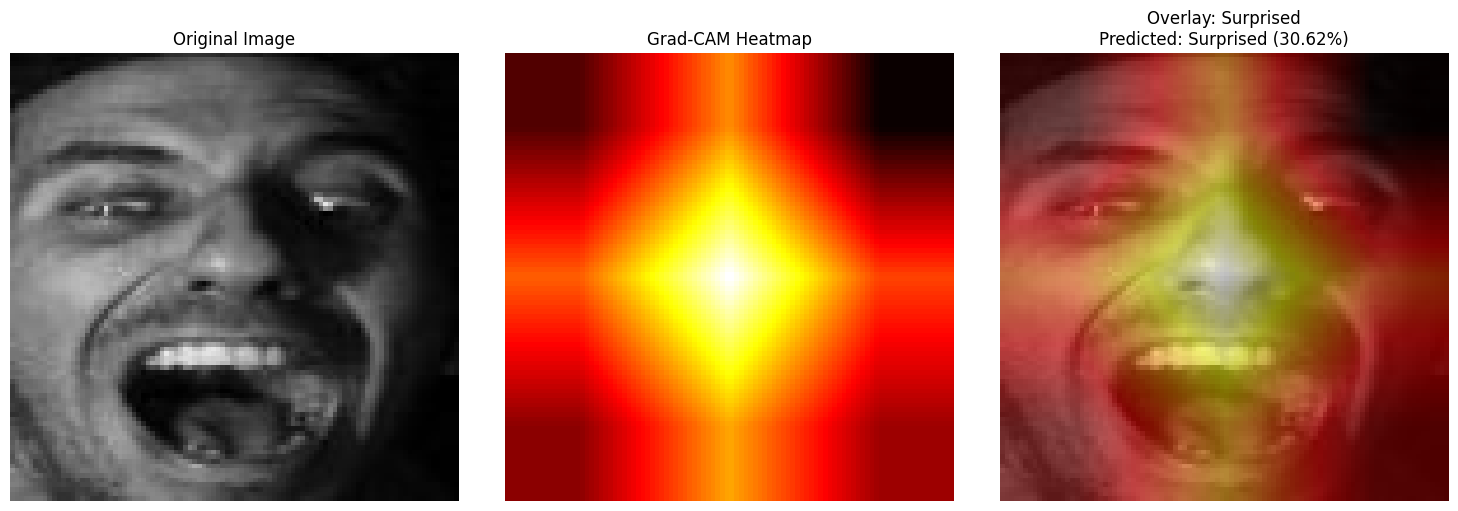

In [87]:
# Test on an image from your validation set
img_path = "data/RAF-DB/DATASET/test/2/test_2285_aligned.jpg"
heatmap, pred_id, conf = grad_cam_visualization(emotion_model, img_path)

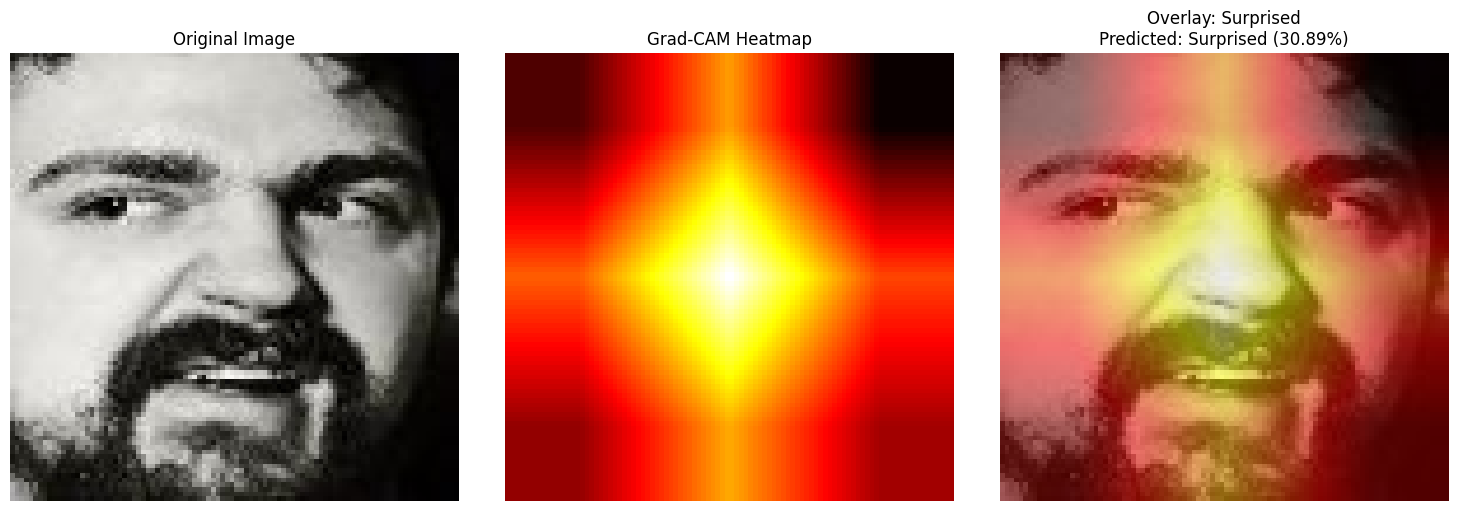

In [74]:
# Test on an image from your validation set
img_path = "data/RAF-DB/DATASET/test/3/test_0007_aligned.jpg"
heatmap, pred_id, conf = grad_cam_visualization(emotion_model, img_path)

In [69]:
print("Model layers:")
for i, layer in enumerate(emotion_model.layers):
    print(f"{i}: {layer.name}")
    if hasattr(layer, "output_shape"):
        print(f"   Output shape: {layer.output_shape}")

Model layers:
0: input_image
1: rescale
2: mobilenetv2_1.00_96
   Output shape: (None, 3, 3, 1280)
3: gap
4: dropout
5: classifier


# GRADCAM

In [ ]:
# Test on an image from your validation set
img_path = "data/RAF-DB/DATASET/test/2/test_1477_aligned.jpg"
heatmap, pred_id, conf = grad_cam_visualization(emotion_model, img_path)

In [43]:
from pathlib import Path

image_path = Path("data/RAF-DB/DATASET/test/2/test_1477_aligned.jpg")
print(image_path, image_path.exists())

data/RAF-DB/DATASET/test/2/test_1477_aligned.jpg True


In [44]:
from PIL import Image
import numpy as np


def load_and_preprocess_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32")
    img_uint8 = arr.astype("uint8")
    img_batch = np.expand_dims(arr, axis=0)  # (1, 96, 96, 3)
    return img_uint8, img_batch

In [45]:
emotion_map = {
    0: "Surprise",
    1: "Fear",
    2: "Disgust",
    3: "Happy",
    4: "Sad",
    5: "Angry",
    6: "Neutral",
}

In [46]:
LAST_CONV_LAYER = "block_16_project"

In [49]:
import tensorflow as tf
import numpy as np


def make_gradcam_heatmap(
    img_batch, model, pred_index=None, conv_layer_name="block_16_project"
):
    """
    img_batch: (1, 96, 96, 3) float32, raw pixels 0–255 (model has Rescaling)
    model:     your emotion_model built with MobileNetV2
    """

    # 1. Get the MobileNetV2 backbone inside the model
    mobilenet = model.get_layer("mobilenetv2_1.00_96")

    # 2. Get the last conv layer *inside* MobileNetV2
    last_conv_layer = mobilenet.get_layer(conv_layer_name)

    # 3. Build a model: input_image -> (conv feature maps, final predictions)
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output],
    )

    # 4. Forward + gradient
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_batch, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_score = preds[:, pred_index]

    grads = tape.gradient(class_score, conv_outputs)  # (1, H, W, C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)

    conv_outputs = conv_outputs[0]  # (H, W, C)
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)  # (H, W)

    # 5. ReLU + normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-10

    return heatmap.numpy()

In [51]:
img, img_batch = load_and_preprocess_image(
    "data/RAF-DB/DATASET/test/2/test_1477_aligned.jpg"
)

probs = emotion_model.predict(img_batch, verbose=0)[0]
pred_idx = int(np.argmax(probs))
pred_label = emotion_map[pred_idx]
pred_conf = float(probs[pred_idx])
print(f"Predicted: {pred_label} (confidence {pred_conf:.3f})")

heatmap = make_gradcam_heatmap(img_batch, emotion_model, pred_index=pred_idx)

heatmap_resized = (
    tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()
)

Predicted: Happy (confidence 0.595)


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m6170297776\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[191., 165., 142.],\n         [191., 165., 142.],\n         [191., 165., 142.],\n         ...,\n         [ 99.,  77.,  66.],\n         [ 97.,  75.,  64.],\n         [ 93.,  71.,  60.]],\n\n        [[192., 166., 143.],\n         [192., 166., 143.],\n         [192., 166., 143.],\n         ...,\n         [ 86.,  64.,  53.],\n         [ 88.,  64.,  54.],\n         [ 85.,  63.,  52.]],\n\n        [[194., 168., 145.],\n         [193., 167., 144.],\n         [193., 167., 144.],\n         ...,\n         [ 98.,  74.,  62.],\n         [103.,  76.,  65.],\n         [102.,  78.,  66.]],\n\n        ...,\n\n        [[ 44.,  41.,  26.],\n         [ 36.,  32.,  20.],\n         [ 35.,  30.,  22.],\n         ...,\n         [ 34.,  32.,  30.],\n         [ 27.,  26.,  24.],\n         [ 34.,  33.,  31.]],\n\n        [[ 48.,  45.,  30.],\n         [ 40.,  36.,  24.],\n         [ 33.,  29.,  20.],\n         ...,\n         [ 35.,  34.,  32.],\n         [ 28.,  27.,  25.],\n         [ 35.,  34.,  32.]],\n\n        [[ 53.,  50.,  35.],\n         [ 46.,  42.,  30.],\n         [ 38.,  34.,  26.],\n         ...,\n         [ 36.,  35.,  33.],\n         [ 28.,  27.,  25.],\n         [ 35.,  34.,  32.]]]], dtype=float32)\n  • training=False\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

In [50]:
import matplotlib.pyplot as plt

# pick an image
img_path = "data/RAF-DB/DATASET/test/2/test_1477_aligned.jpg"

img, img_batch = load_and_preprocess_image(img_path)

probs = emotion_model.predict(img_batch, verbose=0)[0]
pred_idx = int(np.argmax(probs))
pred_label = emotion_map[pred_idx]
pred_conf = float(probs[pred_idx])
print(f"Predicted: {pred_label} (confidence {pred_conf:.3f})")

# note: model has a Rescaling layer, so img_batch (0–255) is fine;
# the model will rescale internally

heatmap = make_gradcam_heatmap(img_batch, emotion_model, pred_index=pred_idx)

heatmap_resized = (
    tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()
)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap_resized, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Overlay: {pred_label}")
plt.imshow(img)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.4)
plt.axis("off")

plt.tight_layout()
plt.show()

Predicted: Happy (confidence 0.595)


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m6170297776\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[191., 165., 142.],\n         [191., 165., 142.],\n         [191., 165., 142.],\n         ...,\n         [ 99.,  77.,  66.],\n         [ 97.,  75.,  64.],\n         [ 93.,  71.,  60.]],\n\n        [[192., 166., 143.],\n         [192., 166., 143.],\n         [192., 166., 143.],\n         ...,\n         [ 86.,  64.,  53.],\n         [ 88.,  64.,  54.],\n         [ 85.,  63.,  52.]],\n\n        [[194., 168., 145.],\n         [193., 167., 144.],\n         [193., 167., 144.],\n         ...,\n         [ 98.,  74.,  62.],\n         [103.,  76.,  65.],\n         [102.,  78.,  66.]],\n\n        ...,\n\n        [[ 44.,  41.,  26.],\n         [ 36.,  32.,  20.],\n         [ 35.,  30.,  22.],\n         ...,\n         [ 34.,  32.,  30.],\n         [ 27.,  26.,  24.],\n         [ 34.,  33.,  31.]],\n\n        [[ 48.,  45.,  30.],\n         [ 40.,  36.,  24.],\n         [ 33.,  29.,  20.],\n         ...,\n         [ 35.,  34.,  32.],\n         [ 28.,  27.,  25.],\n         [ 35.,  34.,  32.]],\n\n        [[ 53.,  50.,  35.],\n         [ 46.,  42.,  30.],\n         [ 38.,  34.,  26.],\n         ...,\n         [ 36.,  35.,  33.],\n         [ 28.,  27.,  25.],\n         [ 35.,  34.,  32.]]]], dtype=float32)\n  • training=False\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

In [35]:
print(model.input)
print(model.output)
print(last_conv_layer.output)

NameError: name 'model' is not defined

In [19]:
for layer in emotion_model.layers:
    print(layer.name)

input_layer_1
mobilenetv2_1.00_96
global_average_pooling2d
dropout
dense


In [23]:
base = emotion_model.get_layer("mobilenetv2_1.00_96")
for layer in base.layers[-10:]:
    print(layer.name, type(layer))

block_16_expand_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block_16_expand_relu <class 'keras.src.layers.activations.relu.ReLU'>
block_16_depthwise <class 'keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>
block_16_depthwise_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block_16_depthwise_relu <class 'keras.src.layers.activations.relu.ReLU'>
block_16_project <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
block_16_project_BN <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
Conv_1 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv_1_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
out_relu <class 'keras.src.layers.activations.relu.ReLU'>
